# 🎮 AI Guessing Game – Starter Template (NiceGPU)

This notebook is the starter template for the **Big Project**.
You'll assemble a simple AI-powered game that uses:
- **AI images** (generated in Session 1)
- **Image classifier** (trained in Session 2)
- **Sentiment analysis** + **Chatbot persona** (Session 3)
- A **game loop** (this notebook)

> Tip: Run cells in order. If something breaks, restart the kernel and run from the top.


## 0) Setup & GPU Check

In [1]:
!pip -q install torch torchvision transformers diffusers accelerate datasets safetensors pillow matplotlib --extra-index-url https://download.pytorch.org/whl/cu121
import torch, platform
print('Python:', platform.python_version())
print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('GPU:', torch.cuda.get_device_name(0))

Python: 3.13.8
CUDA available: False


## 1) Project Structure

We'll use the following folders:

```
game_assets/          # put your generated images here (from Session 1)
models/               # save/load your trained classifier here (from Session 2)
dialogue/             # optional: any text assets for chatbot prompts
```

Create them now if they don't exist.


In [1]:
from pathlib import Path
for d in ["game_assets", "models", "dialogue"]:
    Path(d).mkdir(parents=True, exist_ok=True)
print("Folders ready!")

Folders ready!


## 2) Load & Display Game Assets (Images)

Found 6 image assets.


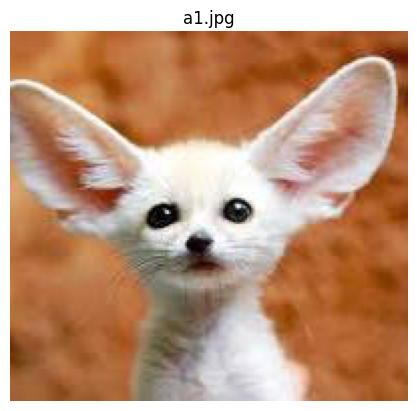

In [2]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

ASSET_DIR = Path("game_assets")
assets = sorted([p for p in ASSET_DIR.glob("**/*") if p.suffix.lower() in {".png",".jpg",".jpeg"}])
print(f"Found {len(assets)} image assets.")
if assets:
    img = Image.open(assets[0])
    plt.imshow(img); plt.axis('off'); plt.title(assets[0].name); plt.show()
else:
    print("Put images into game_assets/ and rerun this cell.")

## 3) Image Classifier – Load & Predict

In [4]:
# Load a trained classifier from Session 2 (if available).
# Expecting a PyTorch .pt or .pth checkpoint that matches your model code.
import torch, torchvision.transforms as T
from PIL import Image
from pathlib import Path

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_PATH = Path("models/classifier.pt")  # TODO: update if your filename differs

# Define the same model architecture you trained (e.g., ResNet18 with num_classes=your classes).
try:
    from torchvision.models import resnet18
    num_classes = 10  # TODO: change to match your training setup
    model = resnet18(num_classes=num_classes).to(DEVICE)
    if MODEL_PATH.exists():
        model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
        print(f"Loaded classifier: {MODEL_PATH}")
    else:
        print("No trained classifier found at models/classifier.pt. Using untrained model (predictions will be random).")
    model.eval()
except Exception as e:
    print("Error loading model:", e)

# Simple transform; adjust to match your training preprocessing
img_tfms = T.Compose([T.Resize((32,32)), T.ToTensor()])

def predict_image(img_path, classes=None):
    img = Image.open(img_path).convert("RGB")
    x = img_tfms(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = model(x)
        pred = logits.argmax(1).item()
    if classes and 0 <= pred < len(classes):
        return classes[pred]
    return str(pred)

# Try on the first asset
classes = ["class0","class1","class2","class3","class4","class5","class6","class7","class8","class9"]  # TODO: replace
from pathlib import Path
assets = sorted([p for p in Path("game_assets").glob("**/*") if p.suffix.lower() in {'.png','.jpg','.jpeg'}])
if assets:
    print("Prediction:", predict_image(assets[0], classes=classes))
else:
    print("No assets yet to predict on.")

No trained classifier found at models/classifier.pt. Using untrained model (predictions will be random).
Prediction: class1


## 4) Sentiment Analysis – Quick Feedback

In [6]:
from transformers import pipeline
sentiment = pipeline('sentiment-analysis', model="distilbert-base-uncased-finetuned-sst-2-english", device=0 if __import__('torch').cuda.is_available() else -1)
print(sentiment("I love this game!") )

C:\Users\ai\miniconda3\envs\torch312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ai\.cache\huggingface\hub\models--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling

[{'label': 'POSITIVE', 'score': 0.9998830556869507}]


## 5) Chatbot Persona – Game Master Responses

In [7]:
from transformers import pipeline
gen = pipeline('text-generation', model='gpt2', device=0 if __import__('torch').cuda.is_available() else -1)

def game_master_reply(context, max_new_tokens=60):
    persona = "You are a friendly Game Master. Encourage players, keep answers under 40 words, and be school-appropriate."
    prompt = f"""{persona}
Context: {context}
Reply:"""
    out = gen(prompt, max_new_tokens=max_new_tokens, do_sample=True, temperature=0.9)[0]['generated_text']
    return out

print(game_master_reply("The player guessed 'cat' and it was correct!"))

C:\Users\ai\miniconda3\envs\torch312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ai\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better 

You are a friendly Game Master. Encourage players, keep answers under 40 words, and be school-appropriate.
Context: The player guessed 'cat' and it was correct!
Reply:
The story is so long and convoluted that it can feel like a book about someone trying to get a bad boy. I'll give my advice (at least) before I start a game, but if you are willing to learn, keep your eye out for the most basic stuff.
I want


## 6) Game Loop – Putting It All Together


=== New Round ===


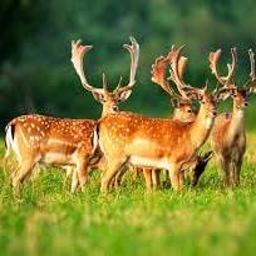

Your guess:  dear


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


❌ Not quite. It was: class5
GM: You are a friendly Game Master. Encourage players, keep answers under 40 words, and be school-appropriate.
Context: Player guessed 'dear'. Truth is 'class5'. Sentiment=POSITIVE
Reply: I know a game, and it's a close call to the next question: If someone has a guess from class, have a good one...


My point. So there's no way to have all the answers, but if they should all guess correctly and say "You guessed from class,"
Score: 0

=== New Round ===


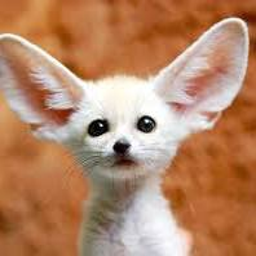

Your guess:  3


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


❌ Not quite. It was: class1
GM: You are a friendly Game Master. Encourage players, keep answers under 40 words, and be school-appropriate.
Context: Player guessed '3'. Truth is 'class1'. Sentiment=NEGATIVE
Reply: The only thing I can remember of you other than that you weren't allowed to go on a casual night.
Might be possible to answer that question.
Example: What happened yesterday after you said that you'd been looking for a game of Scrabble, but that you didn't get
Score: 0

=== New Round ===


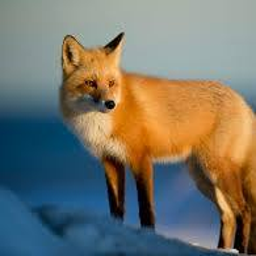

In [ ]:
from pathlib import Path
from PIL import Image
import random

SCORE = 0
ROUND_LIMIT = 5

def play_round(img_path):
    global SCORE
    print("\n=== New Round ===")
    display(Image.open(img_path).resize((256,256)))
    guess = input("Your guess: ").strip()
    # Classifier prediction
    pred_label = predict_image(img_path, classes=classes)
    correct = (guess.lower() == str(pred_label).lower())
    # Sentiment feedback
    fb = sentiment(f"I guessed {guess}.")[0]
    # Chatbot response
    gm = game_master_reply(f"Player guessed '{guess}'. Truth is '{pred_label}'. Sentiment={fb['label']}")
    # Score update
    if correct:
        SCORE += 1
        print("✅ Correct!")
    else:
        print(f"❌ Not quite. It was: {pred_label}")
    print("GM:", gm)
    print("Score:", SCORE)

# Pick random images for ROUNDS
assets = sorted([p for p in Path("game_assets").glob("**/*") if p.suffix.lower() in {'.png','.jpg','.jpeg'}])
if len(assets) < ROUND_LIMIT:
    print(f"Need at least {ROUND_LIMIT} images in game_assets/. Currently: {len(assets)}")
else:
    choices = random.sample(assets, ROUND_LIMIT)
    for p in choices:
        play_round(p)

print("\nGame over! Final Score:", SCORE)